<a href="https://colab.research.google.com/github/talha-q/talha_Geo6805/blob/main/Assignment2_Intro%20to%20Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 1

Answer: The main difference between the two dataset class approaches is the ImageFolder class, in tutorial the code uses ImageFolder Class from torchvision that takes data directory and performs transformations on it automatically, and also it automatically uses PIL to open the images, however, in the second approach we manually have to do the transformations and have to manually apply the PIL for image transformations. ImageFolder assumes dataset is organized into subfolders, whereas in second code, we have to specify the folder structure.

#Assignment 2

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
import random
import shutil
from glob import glob
from osgeo import gdal
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import timm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
PyTorch version 2.5.1+cu124
Torchvision version 0.20.1+cu124
Numpy version 1.26.4
Pandas version 2.2.2


1. Dataset Construction

In [9]:

def split_and_export_dataset_with_gdal(dataset_dir, output_dir):
    selected_training_imgs = []
    selected_validation_imgs = []
    selected_test_imgs = []

    os.makedirs(output_dir, exist_ok=True)
    train_dir = os.path.join(output_dir, 'selected_training_imgs')
    val_dir = os.path.join(output_dir, 'selected_validation_imgs')
    test_dir = os.path.join(output_dir, 'selected_test_imgs')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    class_folders = os.listdir(dataset_dir)

    for class_folder in class_folders:
        class_path = os.path.join(dataset_dir, class_folder)
        if os.path.isdir(class_path):
            image_paths = glob(os.path.join(class_path, '*.tif'))

            random.shuffle(image_paths)

            num_images = len(image_paths)
            train_end = int(0.7 * num_images)
            val_end = train_end + int(0.1 * num_images)

            train_imgs = image_paths[:train_end]
            val_imgs = image_paths[train_end:val_end]
            test_imgs = image_paths[val_end:]

            selected_training_imgs.extend(train_imgs)
            selected_validation_imgs.extend(val_imgs)
            selected_test_imgs.extend(test_imgs)

            train_class_dir = os.path.join(train_dir, class_folder)
            val_class_dir = os.path.join(val_dir, class_folder)
            test_class_dir = os.path.join(test_dir, class_folder)

            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(val_class_dir, exist_ok=True)
            os.makedirs(test_class_dir, exist_ok=True)

            for img_path in train_imgs + val_imgs + test_imgs:
                dataset = gdal.Open(img_path)

                if dataset is None:
                    continue

                if img_path in train_imgs:
                    shutil.copy(img_path, train_class_dir)
                elif img_path in val_imgs:
                    shutil.copy(img_path, val_class_dir)
                else:
                    shutil.copy(img_path, test_class_dir)

    return selected_training_imgs, selected_validation_imgs, selected_test_imgs


dataset_dir = r'/content/drive/MyDrive/UCMerced_LandUse/UCMerced_LandUse/Images'
output_dir = r'/content/drive/MyDrive/split_ucmerced_dataset'

selected_train, selected_val, selected_test = split_and_export_dataset_with_gdal(dataset_dir, output_dir)


In [10]:
training_dataset = r"/content/drive/MyDrive/split_ucmerced_dataset/selected_training_imgs"
print(os.listdir(training_dataset))

['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'mediumresidential', 'mobilehomepark', 'golfcourse', 'parkinglot', 'intersection', 'overpass', 'harbor', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


In [12]:

class MyDataset(Dataset):

    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index]

training_dataset = r"/content/drive/MyDrive/split_ucmerced_dataset/selected_training_imgs"

dataset = MyDataset(training_dataset)

print(len(dataset))
image, label = dataset[5]
print(dataset[5])
print(image)
print(label, "\n", "~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


target_to_class = {v: k for k, v in ImageFolder(training_dataset).class_to_idx.items()}
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
dataset_transformed = MyDataset(training_dataset, transform=transform)
image2, label = dataset_transformed[5]
print(dataset_transformed[5])
print(image2)
print(image2.shape)
print(label)



1474
(<PIL.Image.Image image mode=RGB size=256x256 at 0x7976D2C68F90>, 0)
<PIL.Image.Image image mode=RGB size=256x256 at 0x7976D72E10D0>
0 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
(tensor([[[0.5020, 0.2549, 0.2157,  ..., 0.2588, 0.3451, 0.3961],
         [0.4588, 0.2275, 0.3176,  ..., 0.2980, 0.3804, 0.4431],
         [0.3647, 0.2392, 0.4510,  ..., 0.3608, 0.5098, 0.5608],
         ...,
         [0.5725, 0.5882, 0.3020,  ..., 0.4588, 0.2745, 0.2863],
         [0.5569, 0.4667, 0.2157,  ..., 0.4000, 0.2510, 0.3490],
         [0.4863, 0.3255, 0.1725,  ..., 0.3333, 0.3255, 0.4902]],

        [[0.5059, 0.2627, 0.2235,  ..., 0.2863, 0.4000, 0.4510],
         [0.4588, 0.2314, 0.3333,  ..., 0.3216, 0.4235, 0.4863],
         [0.3608, 0.2353, 0.4706,  ..., 0.3725, 0.5294, 0.5765],
         ...,
         [0.5843, 0.5922, 0.2980,  ..., 0.4745, 0.2706, 0.2745],
         [0.5686, 0.4627, 0.2039,  ..., 0.4000, 0.2392, 0.3412],
         [0.5059, 0.3216, 0.1608,  ..., 0.3255, 0.3216, 0.5020]],

        

In [13]:
dataloader  = DataLoader(dataset_transformed, batch_size=32, shuffle=True)
for imgs, labels in dataloader:
    break
imgs.shape, labels.shape


(torch.Size([32, 3, 224, 224]), torch.Size([32]))

Creating a Pytorch Model

Tasks

1. Data Loader
2. Model Structure Definition
3. Training Loop

Step1: Create Dataset and DataLoader

In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

In [15]:
print("System Version:", sys.version)
print("Pytorch Version:", torch.__version__)
print("TorchVision version:", torchvision.__version__)
print("Numpy Version:", np.__version__)
print("Pandas version", pd.__version__)

System Version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Pytorch Version: 2.5.1+cu124
TorchVision version: 0.20.1+cu124
Numpy Version: 1.26.4
Pandas version 2.2.2


Defining Pipeline

In [16]:
class MyDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        # Initialize the ImageFolder dataset
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        # Return the size of the dataset
        return len(self.data)

    def __getitem__(self, index):
        # Get the item at the specified index
        return self.data[index]


In [17]:
training_dataset ="/content/drive/MyDrive/split_ucmerced_dataset/selected_training_imgs"


In [18]:
dataset=MyDataset(training_dataset)

In [19]:
print(len(dataset))
image,label=dataset[5]

1474


In [20]:
print(dataset[5])
print(image)
print(label, "\n", "~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

(<PIL.Image.Image image mode=RGB size=256x256 at 0x7976D2D821D0>, 0)
<PIL.Image.Image image mode=RGB size=256x256 at 0x7976D3A90610>
0 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [21]:
target_to_class = {v: k for k, v in ImageFolder(training_dataset).class_to_idx.items()}


In [22]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])


In [23]:
# create an instance of the dataset class with transformation, since it is a tensor, you can check its shape ()
dataset_transformed = MyDataset(training_dataset, transform=transform)
image2, label = dataset_transformed[5]

In [24]:
print(dataset_transformed[5])
print(image2)
print(image2.shape) # the format would be [channel, row, column]
print(label)

(tensor([[[0.5020, 0.2549, 0.2157,  ..., 0.2588, 0.3451, 0.3961],
         [0.4588, 0.2275, 0.3176,  ..., 0.2980, 0.3804, 0.4431],
         [0.3647, 0.2392, 0.4510,  ..., 0.3608, 0.5098, 0.5608],
         ...,
         [0.5725, 0.5882, 0.3020,  ..., 0.4588, 0.2745, 0.2863],
         [0.5569, 0.4667, 0.2157,  ..., 0.4000, 0.2510, 0.3490],
         [0.4863, 0.3255, 0.1725,  ..., 0.3333, 0.3255, 0.4902]],

        [[0.5059, 0.2627, 0.2235,  ..., 0.2863, 0.4000, 0.4510],
         [0.4588, 0.2314, 0.3333,  ..., 0.3216, 0.4235, 0.4863],
         [0.3608, 0.2353, 0.4706,  ..., 0.3725, 0.5294, 0.5765],
         ...,
         [0.5843, 0.5922, 0.2980,  ..., 0.4745, 0.2706, 0.2745],
         [0.5686, 0.4627, 0.2039,  ..., 0.4000, 0.2392, 0.3412],
         [0.5059, 0.3216, 0.1608,  ..., 0.3255, 0.3216, 0.5020]],

        [[0.4706, 0.2392, 0.2275,  ..., 0.2627, 0.3647, 0.4039],
         [0.4353, 0.2235, 0.3216,  ..., 0.3059, 0.3961, 0.4314],
         [0.3529, 0.2392, 0.4471,  ..., 0.3647, 0.5098, 0

In [25]:
dataloader  = DataLoader(dataset_transformed, batch_size=32, shuffle=True)
for imgs, labels in dataloader:
    break
imgs.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

-----------------------------

Step 2: Create a Pytorch Model

In [26]:
training_dir=r"/content/drive/MyDrive/split_ucmerced_dataset/selected_training_imgs"
class_folders = os.listdir(training_dir)

print(f"Number of classes: {len(class_folders)}")

Number of classes: 21


In [27]:
class LandUseClassifier(nn.Module):
    def __init__(self, num_classes=21):
        super(LandUseClassifier, self).__init__()
        self.fully_connected_0 = nn.Linear(3*224*224, 128)
        self.fully_connected_1 = nn.Linear(128, 128)
        self.fully_connected_2 = nn.Linear(128, 128)
        self.fully_connected_3 = nn.Linear(128, 128)
        self.fully_connected_4 = nn.Linear(128, 100)
        self.fully_connected_5 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        hidden_1 = self.fully_connected_0(x)
        hidden_1 = F.leaky_relu(hidden_1, negative_slope=0.01)  # LeakyReLU with negative slope of 0.01
        hidden_2 = self.fully_connected_1(hidden_1)
        hidden_2 = F.leaky_relu(hidden_2, negative_slope=0.01)
        hidden_3 = self.fully_connected_2(hidden_2)
        hidden_3 = F.leaky_relu(hidden_3, negative_slope=0.01)
        hidden_4 = self.fully_connected_3(hidden_3)
        hidden_4 = F.leaky_relu(hidden_4, negative_slope=0.01)
        hidden_5 = self.fully_connected_4(hidden_4)
        hidden_5 = F.leaky_relu(hidden_5, negative_slope=0.01)
        output = self.fully_connected_3(hidden_3)
        output = F.log_softmax(output, dim=1)
        return output

model = LandUseClassifier(num_classes=21)
print(model)


LandUseClassifier(
  (fully_connected_0): Linear(in_features=150528, out_features=128, bias=True)
  (fully_connected_1): Linear(in_features=128, out_features=128, bias=True)
  (fully_connected_2): Linear(in_features=128, out_features=128, bias=True)
  (fully_connected_3): Linear(in_features=128, out_features=128, bias=True)
  (fully_connected_4): Linear(in_features=128, out_features=100, bias=True)
  (fully_connected_5): Linear(in_features=100, out_features=21, bias=True)
)


In [28]:
example_out = model(imgs)
print(example_out.shape)

torch.Size([32, 128])


3. Defining the Training Loop

In [29]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_folder = '/content/drive/MyDrive/split_ucmerced_dataset/selected_training_imgs'
valid_folder = '/content/drive/MyDrive/split_ucmerced_dataset/selected_validation_imgs'
test_folder = '/content/drive/MyDrive/split_ucmerced_dataset/selected_test_imgs'

train_dataset = MyDataset(train_folder, transform=transform)
val_dataset = MyDataset(valid_folder, transform=transform)
test_dataset = MyDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

n = 0
for one_batch_of_imgs, one_batch_of_labels in train_loader:
    print(one_batch_of_imgs.shape)
    print(one_batch_of_labels.shape)
    n+=1
print(n)

torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([3

Training Loop

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LandUseClassifier()
model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
num_epoch = 110
train_losses, val_losses = [], []

for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0
    for one_batch_of_imgs, one_batch_of_labels in train_loader:
        one_batch_of_imgs, one_batch_of_labels = one_batch_of_imgs.to(device), one_batch_of_labels.to(device)
        optimizer.zero_grad()
        outputs = model(one_batch_of_imgs)
        loss = loss_func(outputs, one_batch_of_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * one_batch_of_labels.size(0)
    train_loss = float(running_loss / len(train_loader.dataset))
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_func(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epoch} - Train loss: {train_loss}, Validation loss: {val_loss}")

torch.save(model.state_dict(), '3hidden_NN.ckpt')


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/110 - Train loss: 4.093921432339838, Validation loss: 3.5648277101062593


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/110 - Train loss: 3.266835985869533, Validation loss: 3.1083647546314057


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/110 - Train loss: 3.057305917002291, Validation loss: 3.046618534269787


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/110 - Train loss: 2.9812969420625848, Validation loss: 2.986820799963815


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/110 - Train loss: 2.936481129686415, Validation loss: 3.001852898370652


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/110 - Train loss: 2.880307676995949, Validation loss: 2.913975091207595


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/110 - Train loss: 2.84877548580092, Validation loss: 2.8933450267428444


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/110 - Train loss: 2.7678463522097148, Validation loss: 2.9221413521539596


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/110 - Train loss: 2.723119287672004, Validation loss: 2.8769573960985455


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/110 - Train loss: 2.662531711029715, Validation loss: 2.8025616259801955


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/110 - Train loss: 2.5678699974127346, Validation loss: 2.7594380242483956


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/110 - Train loss: 2.5412327919756863, Validation loss: 2.77677709034511


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/110 - Train loss: 2.493076416013037, Validation loss: 2.735260806764875


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/110 - Train loss: 2.3990581954350465, Validation loss: 2.686569513593401


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/110 - Train loss: 2.3457992623586668, Validation loss: 2.6604608603886195


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/110 - Train loss: 2.302736887938294, Validation loss: 2.6967389765239895


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/110 - Train loss: 2.2963424290213204, Validation loss: 2.6566522007896785


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/110 - Train loss: 2.200846603799869, Validation loss: 2.655199334734962


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/110 - Train loss: 2.1816870957572556, Validation loss: 2.671626463390532


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/110 - Train loss: 2.1659256803779137, Validation loss: 2.5812432130177814


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21/110 - Train loss: 2.1211034523745242, Validation loss: 2.7862810134887694


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22/110 - Train loss: 2.107357152604992, Validation loss: 2.6213177590143113


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23/110 - Train loss: 2.0128444900667977, Validation loss: 2.6644317445300874


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24/110 - Train loss: 1.9876318479328337, Validation loss: 2.7567971093314037


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25/110 - Train loss: 1.9122134329020735, Validation loss: 2.8089669659024192


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26/110 - Train loss: 1.8944241471659378, Validation loss: 2.551544339316232


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27/110 - Train loss: 1.85275531203323, Validation loss: 2.532961672828311


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28/110 - Train loss: 1.8080574401845118, Validation loss: 2.5935958657945903


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29/110 - Train loss: 1.7801880008330015, Validation loss: 2.617562929789225


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 30/110 - Train loss: 1.7517239798360795, Validation loss: 2.585042531149728


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 31/110 - Train loss: 1.761865984633302, Validation loss: 2.717030888512021


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 32/110 - Train loss: 1.675412594058944, Validation loss: 2.7152596292041595


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 33/110 - Train loss: 1.6155984760786495, Validation loss: 2.6077871754055932


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 34/110 - Train loss: 1.6322885138694112, Validation loss: 2.6578273160117014


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 35/110 - Train loss: 1.584326297166066, Validation loss: 2.694603865487235


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 36/110 - Train loss: 1.5169333104686142, Validation loss: 2.6831652323404946


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 37/110 - Train loss: 1.5300934324432747, Validation loss: 2.8017252536047073


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 38/110 - Train loss: 1.4826605962930572, Validation loss: 2.6245098477318174


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 39/110 - Train loss: 1.4326451707889138, Validation loss: 2.725546080725534


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 40/110 - Train loss: 1.4180905815704221, Validation loss: 2.598477318173363


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 41/110 - Train loss: 1.3403308477298215, Validation loss: 2.812837128412156


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 42/110 - Train loss: 1.3579255010897302, Validation loss: 2.6079864660898844


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 43/110 - Train loss: 1.2789512486114916, Validation loss: 2.7608126322428386


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 44/110 - Train loss: 1.2703667139909969, Validation loss: 2.7331427778516497


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 45/110 - Train loss: 1.2362391537856539, Validation loss: 2.904371084485735


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 46/110 - Train loss: 1.2016667140549202, Validation loss: 2.7947292282467795


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 47/110 - Train loss: 1.1594243232398376, Validation loss: 2.802258655003139


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 48/110 - Train loss: 1.1199923997171213, Validation loss: 2.8014835176013766


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 49/110 - Train loss: 1.0804894394272866, Validation loss: 2.7953527677626835


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 50/110 - Train loss: 1.1322592231602973, Validation loss: 2.8666220982869466


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 51/110 - Train loss: 1.0478410717590207, Validation loss: 2.7764026528313046


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 52/110 - Train loss: 0.9906623640086305, Validation loss: 2.8465079216730027


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 53/110 - Train loss: 0.9962350763734354, Validation loss: 2.793206332978748


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 54/110 - Train loss: 0.9284980995845924, Validation loss: 2.831793467203776


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 55/110 - Train loss: 0.9132023530543416, Validation loss: 3.134462138584682


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 56/110 - Train loss: 0.9771415934957352, Validation loss: 3.2899772348858063


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 57/110 - Train loss: 0.9591630326844297, Validation loss: 2.935854736963908


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 58/110 - Train loss: 0.8245817194800202, Validation loss: 2.9470466954367502


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 59/110 - Train loss: 0.8820197359030735, Validation loss: 3.011398696899414


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 60/110 - Train loss: 0.7917366050476944, Validation loss: 2.955944488162086


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 61/110 - Train loss: 0.8074013379729749, Validation loss: 3.174546278090704


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 62/110 - Train loss: 0.7996666936085053, Validation loss: 3.1765606971014115


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 63/110 - Train loss: 0.7467416038021466, Validation loss: 3.1748221624465214


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 64/110 - Train loss: 0.7431744054829249, Validation loss: 2.856843344370524


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 65/110 - Train loss: 0.7194755202717826, Validation loss: 3.1325266928899858


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 66/110 - Train loss: 0.7122161443796378, Validation loss: 3.1396258762904576


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 67/110 - Train loss: 0.6377849162656061, Validation loss: 3.2727108864557177


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 68/110 - Train loss: 0.6198571786951663, Validation loss: 3.3476215180896576


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 69/110 - Train loss: 0.6524734571475025, Validation loss: 3.6305626960027784


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 70/110 - Train loss: 0.8084829185193397, Validation loss: 3.5055022330511183


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 71/110 - Train loss: 0.7855704518153839, Validation loss: 3.2632751918974376


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 72/110 - Train loss: 0.5771379779362129, Validation loss: 3.221636526925223


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 73/110 - Train loss: 0.5517640145371695, Validation loss: 3.2631118547348748


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 74/110 - Train loss: 0.5575432043871369, Validation loss: 3.430321416400728


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 75/110 - Train loss: 0.561543031687895, Validation loss: 3.247631508963449


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 76/110 - Train loss: 0.4884797165036363, Validation loss: 3.264522343590146


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 77/110 - Train loss: 0.5220062020999282, Validation loss: 3.4043531190781366


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 78/110 - Train loss: 0.5471246645582418, Validation loss: 3.273921031043643


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 79/110 - Train loss: 0.4482631647764747, Validation loss: 3.8231633731297086


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 80/110 - Train loss: 0.5045354741561041, Validation loss: 3.2431991304670063


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 81/110 - Train loss: 0.44903701084844133, Validation loss: 3.5066799209231423


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 82/110 - Train loss: 0.4100953194147211, Validation loss: 3.3554921059381395


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 83/110 - Train loss: 0.46052052434458013, Validation loss: 3.372743506658645


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 84/110 - Train loss: 0.40065006929951413, Validation loss: 3.664236422947475


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 85/110 - Train loss: 0.4076846378427024, Validation loss: 3.5649366287958055


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 86/110 - Train loss: 0.3678471570685405, Validation loss: 3.6276171684265135


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 87/110 - Train loss: 0.38543835698830387, Validation loss: 3.663189279465448


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 88/110 - Train loss: 0.3867310327724168, Validation loss: 3.640661457606724


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 89/110 - Train loss: 0.3519002341310237, Validation loss: 3.845663225083124


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 90/110 - Train loss: 0.36084913717408434, Validation loss: 3.759797273363386


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 91/110 - Train loss: 0.3053841057411689, Validation loss: 3.6284637996128626


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 92/110 - Train loss: 0.3215476915068429, Validation loss: 3.867061015537807


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 93/110 - Train loss: 0.30326240716989844, Validation loss: 3.8064547902061827


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 94/110 - Train loss: 0.29126467057371075, Validation loss: 3.6493976320539203


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 95/110 - Train loss: 0.29560430921118813, Validation loss: 3.8481143815176826


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 96/110 - Train loss: 0.2906066818994292, Validation loss: 3.8351850237165177


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 97/110 - Train loss: 0.4277207514111918, Validation loss: 3.8857721056256977


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 98/110 - Train loss: 0.2718410144182203, Validation loss: 4.2076318695431665


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 99/110 - Train loss: 0.347979227684974, Validation loss: 3.934260381971087


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 100/110 - Train loss: 0.23211020773107355, Validation loss: 3.8047426132928757


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 101/110 - Train loss: 0.266673557210102, Validation loss: 4.17174634479341


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 102/110 - Train loss: 0.2171378218931534, Validation loss: 3.9968947546822684


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 103/110 - Train loss: 0.20324233678463982, Validation loss: 3.684953090122768


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 104/110 - Train loss: 0.21243821106866265, Validation loss: 3.9420183681306384


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 105/110 - Train loss: 0.1852086250097813, Validation loss: 4.197812430063883


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 106/110 - Train loss: 0.1844738033742946, Validation loss: 4.308274387177967


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 107/110 - Train loss: 0.2079485674304041, Validation loss: 3.9870739982241674


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 108/110 - Train loss: 0.2044057297738954, Validation loss: 3.8802686600458056


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 109/110 - Train loss: 0.2675323947718218, Validation loss: 4.5255675134204685


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 110/110 - Train loss: 0.21716300845954925, Validation loss: 4.246774791535877


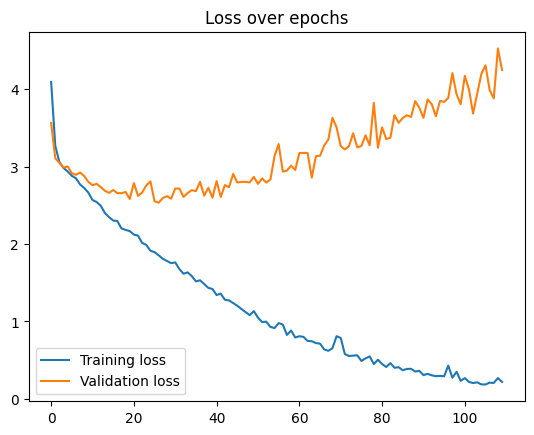

In [32]:
# visualize the loss during training
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

Inference

In [33]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

model = LandUseClassifier(num_classes=21)

model.load_state_dict(torch.load("3hidden_NN.ckpt"))


model.eval()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        prediction = torch.argmax(output, dim = 1)
        print(prediction)

<ipython-input-33-3c5aeb273af0>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("3hidden_NN.ckpt"))


tensor([ 7,  7,  0,  0,  0,  0,  9,  9,  0,  0,  0,  7, 17,  7,  7,  7, 13,  0,
        13,  0,  3, 15,  7,  3,  7, 18,  3,  0,  8,  8,  8,  9],
       device='cuda:0')
tensor([ 4, 18, 18,  8,  9,  9,  2,  1,  2,  9,  9,  2,  2,  2,  9,  9,  2,  2,
         2,  2,  0,  2,  2,  2,  2,  9,  9, 16, 14,  3,  3,  3],
       device='cuda:0')
tensor([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  9,  3,  2,  1,
        12,  6, 16,  4,  4,  8,  1,  7, 20,  4,  9,  9,  7, 17],
       device='cuda:0')
tensor([20, 19, 20, 15,  5,  2,  5,  5,  5,  5,  5,  5,  8, 17,  0,  0,  9,  1,
         1,  5,  8,  5,  5,  8,  8, 20, 20,  4,  2, 16, 13, 16],
       device='cuda:0')
tensor([ 2,  2, 19,  9,  6,  8, 11,  9,  9,  1, 17, 20,  4,  7,  7,  7,  7, 17,
        16,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
       device='cuda:0')
tensor([ 9,  2,  2,  8,  2,  8, 20,  3,  0,  8,  7,  8, 14, 17, 18,  7,  4, 17,
        17, 11,  7,  9,  9,  9,  9,  9,  3,  0,  2,  2,  9,  0],
       dev